In [82]:
from monai.transforms import(
    Compose,
    LoadImaged,
    AddChanneld,
    ToTensord,
    Spacingd,
    Resized,
    CropForegroundd,
    ScaleIntensityRanged,
    Activations,
    Orientationd,
      
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.utils import first, set_determinism
from monai.data import CacheDataset, DataLoader, Dataset
import torch
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import os
from monai.inferers import sliding_window_inference

In [83]:
data_dir = 'C:/Users/adegb/Desktop/Computer Vision Projects/Liver-Tumor-Segmentation/dataset'
model_dir = 'C:/Users/adegb/Desktop/Computer Vision Projects/Liver-Tumor-Segmentation/model'

In [84]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

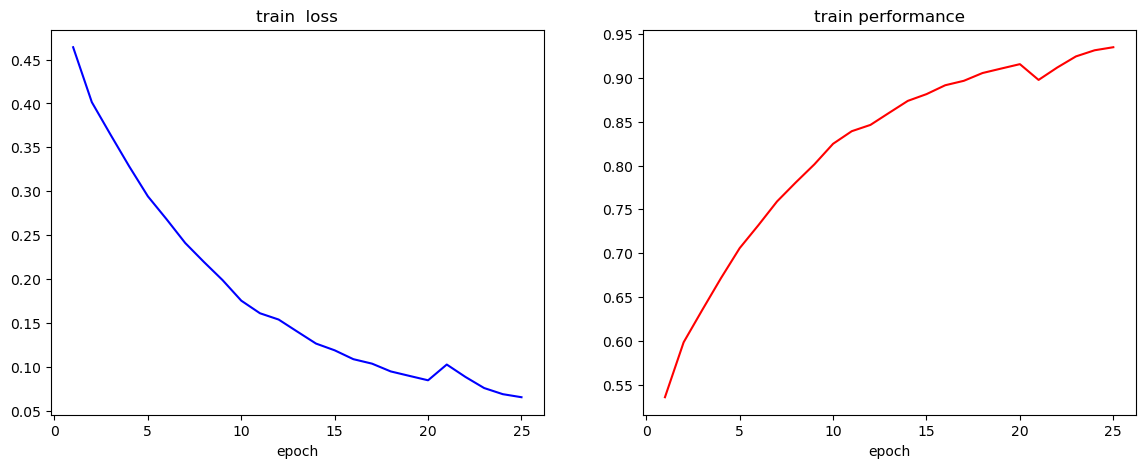

In [85]:
plt.figure("Train result visualisation", (14, 5))
plt.subplot(1, 2, 1)
plt.title("train  loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y, color='blue')

plt.subplot(1, 2, 2)
plt.title("train performance")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y, color='red')

plt.show()

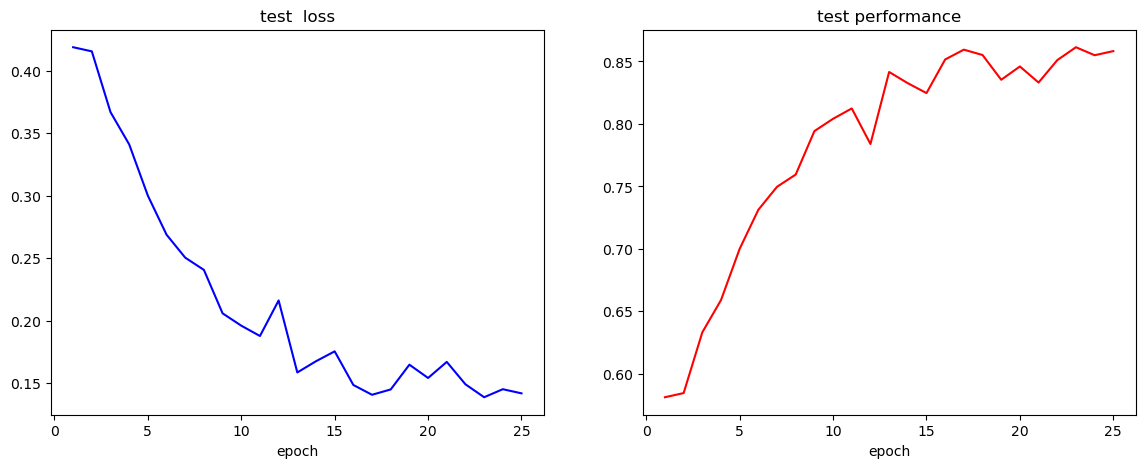

In [86]:
plt.figure("Test result visualisation", (14, 5))
plt.subplot(1, 2, 1)
plt.title("test  loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y, color='blue')

plt.subplot(1, 2, 2)
plt.title("test performance")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y, color='red')
plt.show()

In [87]:
volume_train_path= sorted(glob(os.path.join(data_dir, "TrainData", "*.nii.gz")))
label_train_path = sorted(glob(os.path.join(data_dir, "TrainLabels", "*.nii.gz")))

volume_test_path = sorted(glob(os.path.join(data_dir, "TrainData", "*.nii.gz")))
label_test_path = sorted(glob(os.path.join(data_dir, "TrainLabels", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(volume_train_path, label_train_path)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(volume_test_path, label_test_path)]
test_files = test_files[4:24]

In [88]:
origin_transforms = Compose(
    (
        
        LoadImaged(keys=['vol', 'seg']),
        AddChanneld(keys=['vol', 'seg']),
        ToTensord(keys=['vol', 'seg'])
    )
    
)

test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True), 
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),   
        ToTensord(keys=["vol", "seg"]),
    ]
)

In [89]:
origin_set = Dataset(data=test_files, transform=origin_transforms)
oring_loader = DataLoader(origin_set, batch_size=1)

test_set = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_set, batch_size=1)

In [90]:
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [91]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


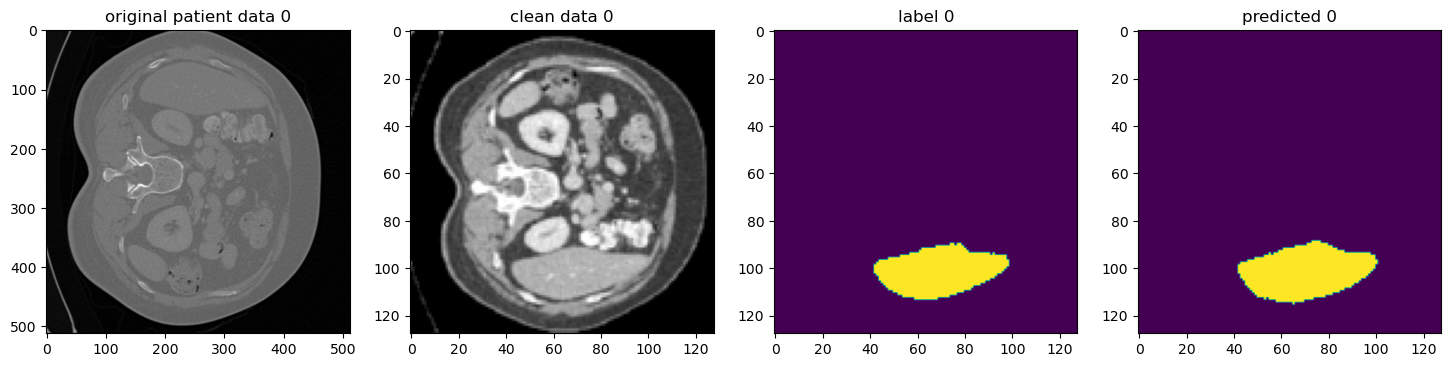

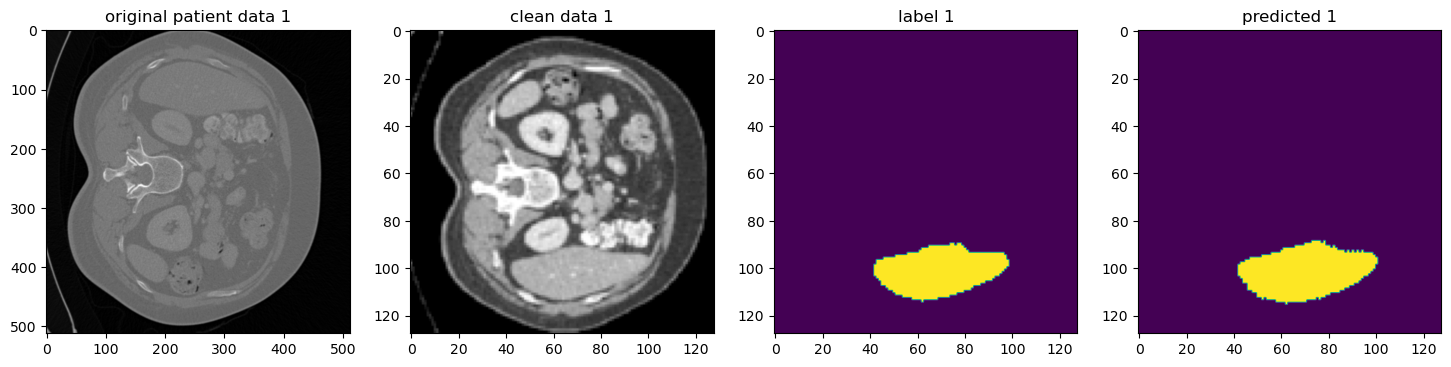

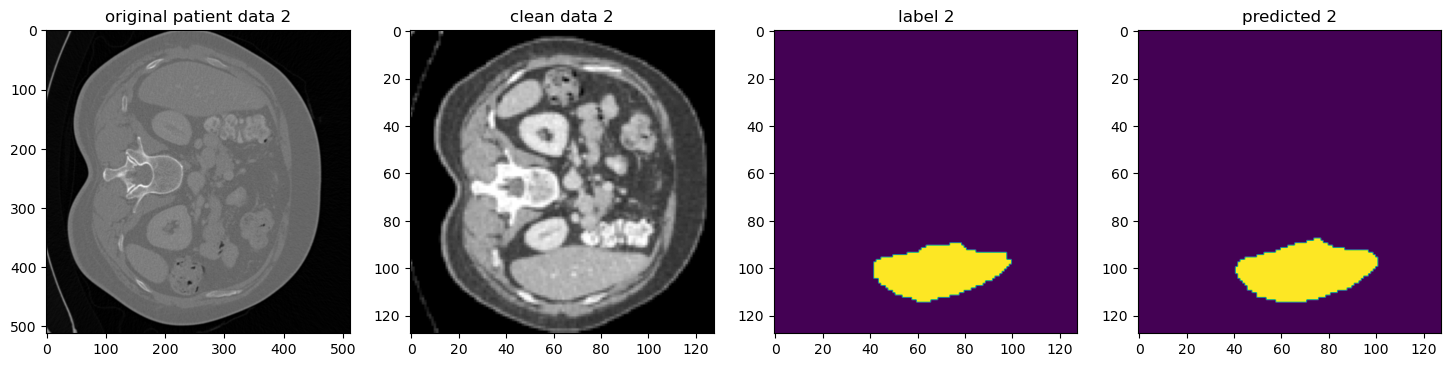

In [92]:
sw_batch_size = 2
roi_size = (128, 128, 64)
with torch.no_grad():
    origina_pat_data = first(oring_loader)
    test_patient = first(test_loader)
    t_volume = test_patient['vol']
    
    
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53
        
    for i in range(3):
        plt.figure("Test", (18, 6))
        
        plt.subplot(1, 4, 1)
        plt.title(f"original patient data {i}")
        plt.imshow(origina_pat_data["vol"][0, 0, :, :, i], cmap="gray")
        
        plt.subplot(1, 4, 2)
        plt.title(f"clean data {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        
        plt.subplot(1, 4, 3)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        
        plt.subplot(1, 4, 4)
        plt.title(f"predicted {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()